First things first!

In [2]:
# importing useful libraries
import pandas as pd
import numpy as np
import math
import datetime as dt
import time
import geopy.distance

import re
import ast
  
import seaborn as sns
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objs as go

import matplotlib.pyplot as plt

%matplotlib inline


In [3]:
# reading the data 
consumer_preferences = pd.read_csv('consumer_preferences.csv')
consumers = pd.read_csv('consumers.csv')
ratings = pd.read_csv('ratings.csv')
restaurant_cuisines = pd.read_csv('restaurant_cuisines.csv')
restaurants = pd.read_csv('restaurants.csv')

In [6]:
#using lowercase column names for easier coding
for dataframe in [consumer_preferences, consumers, ratings, restaurant_cuisines, restaurants]:
  dataframe.columns = [column.lower() for column in dataframe.columns]

In [7]:
consumers.head()

,consumer_id,city,state,country,latitude,longitude,smoker,drink_level,transportation_method,marital_status,children,age,occupation,budget
0,U1001,San Luis Potosi,San Luis Potosi,Mexico,22.139997,-100.978803,No,Abstemious,On Foot,Single,Independent,23,Student,Medium
1,U1002,San Luis Potosi,San Luis Potosi,Mexico,22.150087,-100.983325,No,Abstemious,Public,Single,Independent,22,Student,Low
2,U1003,San Luis Potosi,San Luis Potosi,Mexico,22.119847,-100.946527,No,Social Drinker,Public,Single,Independent,23,Student,Low
3,U1004,Cuernavaca,Morelos,Mexico,18.867000,-99.183000,No,Abstemious,Public,Single,Independent,72,Employed,Medium
4,U1005,San Luis Potosi,San Luis Potosi,Mexico,22.183477,-100.959891,No,Abstemious,Public,Single,Independent,20,Student,Medium


<Axes: >

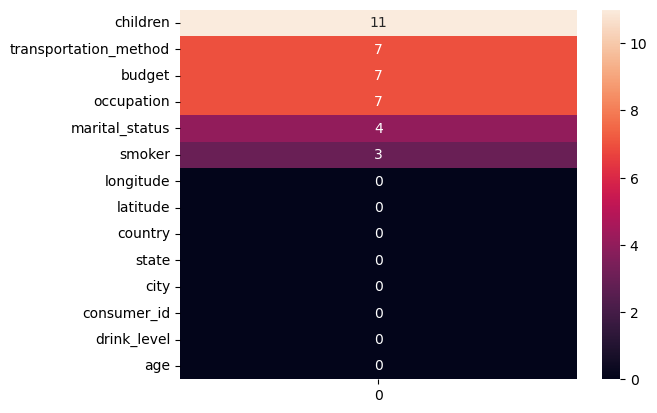

In [8]:
#handling missing data
sns.heatmap(pd.DataFrame(consumers.isna().sum().sort_values(ascending=False)), annot=True)

In [9]:
consumers[consumers['children'].isna()]
# we probably can fill missing children records with "no children" since they are probably all single and mostly young and student
# since other missing values are rare it might be a good idea to drop those columns. please note that this theory is just hypothetical and we can not make sure this is a totaly valid desicion.
consumers['children'] = consumers['children'].fillna('no_children')
consumers.dropna(inplace=True)

as it noted in the documents, all the consumers all from mexico

In [10]:
consumers['country'].value_counts()

Mexico    125
Name: country, dtype: int64

In [11]:
consumers['state_city'] = consumers.apply(lambda x: str(tuple([x['state'], x['city']])), axis=1)
px.bar(data_frame=consumers['state_city'].value_counts()/len(consumers), height=500, width=700, title='where do consumers live?')

In [14]:
px.histogram(data_frame=consumers, x='smoker', color='drink_level',height=350, width=700, title='consumers bad habits in a glance')

It looks like abstemious drinkers are pretty rare, but non-smoker drinkers are common.

In [15]:
px.bar(consumers['transportation_method'].value_counts()/len(consumers),height=350, width=700, title = 'proportion of transportation methods used by consumers')

In [16]:
px.bar(consumers['marital_status'].value_counts()/len(consumers),height=350, width=700,title = 'proportion of consumers marital status')

In [17]:
px.histogram(data_frame=consumers, x='age', color='marital_status',height=350, width=700, title='consumers age and marital status')

it could also be a good idea to look at the proportion of data. (what percentage of consumers are in what age group?) 

In [18]:
px.histogram(data_frame=consumers, x='age', color='transportation_method',height=350, width=700, title='consumers age and transportation group')

In [19]:
# fill budget with ordinal values for better visualization
consumers['budget'] = consumers['budget'].apply(lambda x: 0 if x=='Low' else 2 if x=='High'  else 1)
px.scatter(data_frame=consumers.sort_values('budget'), x='age', y='budget',height=350, width=700, title = 'age Vs budget')

In [20]:
px.histogram(data_frame=consumers, x='age', color='occupation',height=350, width=700, title='consumers age and occupation')

It is interesting that we observe a few elite students. It is also important to note that we have only one unemployed consumer.

In the next two plots we will also take a look at consumers bad habits based on their age group.

In [21]:
px.histogram(data_frame=consumers, x='age', color='smoker',height=350, width=700, title='consumers age and occupation')

In [22]:
px.histogram(data_frame=consumers, x='age', color='drink_level',height=350, width=700, title='consumers age and occupation')

It's a relief that we don't see any under-age drinker or smokers!

It is obvious that our data from consumers are mostly distributed in one age group so we can not conclude on age groups due to this unbalanced data.

before we do any merges and cross-table analysis let's take a look at restaurants data too.

<Axes: >

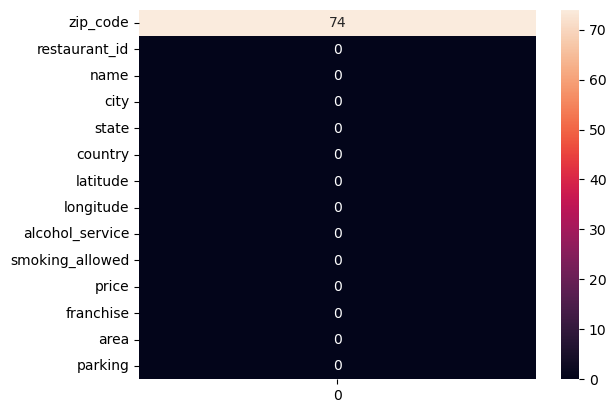

In [23]:
sns.heatmap(pd.DataFrame(restaurants.isna().sum().sort_values(ascending=False)), annot=True)

It looks like we have almost everything except some retaurants zip codes. we can leave them unchanged since we have other geographical data.

In [24]:
restaurants['state_city'] = restaurants.apply(lambda x: str(tuple([x['state'], x['city']])), axis=1)
px.bar(data_frame=restaurants['state_city'].value_counts()/len(restaurants), height=500, width=700, title='where are restaurants located?')

In [25]:
# flashback!
px.bar(data_frame=consumers['state_city'].value_counts()/len(consumers), height=500, width=700, title='where do consumers live?')

It looks like consumers and restaurants location are from the same distribution so our analysis could be reliable.

In [26]:
px.histogram(data_frame=restaurants, x='alcohol_service', color='smoking_allowed',height=350, width=700, title='restaurants policies')

It seems that smoking policies are mostly independent from alcohol services. As we can see in the next plot, smoking policies are roughly dependent on area.

In [27]:
px.histogram(data_frame=restaurants, x='area', color='smoking_allowed',height=350, width=700, title='smoking policies and area')

about 80% of closed-area restaurants have no smoking policies, on the other hand, about 33% of open-area restaurants have no smoking policies.



In [28]:
px.histogram(data_frame=restaurants, x='franchise', color='price',height=350, width=700, title='franchise status and price levels')

22% of non-franchise retauants are high priced and about 4% of franchised restaurants are high priced.

In [29]:
px.histogram(data_frame=restaurants, x='parking', color='price',height=350, width=700, title='price level and parking availability')

In [30]:
px.histogram(data_frame=restaurants, x='state_city', color='price',height=500, width=700, title='price level in cities')

Now that we have some ideas about our data. let's do some analysis based on all data combined. 
Since we do not aim to develop a predictive model or any sort of recommender system, we can make some assumptions about consumers and their opinion about restaurants, then we can validate our assumptions with the ratings. With this procedure, we can develop some insights and validate our hypotheses.  

In [31]:
# processing the data
consumers = pd.merge(consumers,pd.DataFrame(consumer_preferences.groupby('consumer_id').apply(lambda x: list(x['preferred_cuisine'])),columns=['consumer_prefrences']), on='consumer_id', how='left')
restaurants = pd.merge(restaurants, pd.DataFrame(restaurant_cuisines.groupby('restaurant_id').apply(lambda x: list(x['cuisine'])),columns=['cuisine']), on='restaurant_id', how='left')

We don't have cuisine information about some of closed-area restaurants and one exception which is an open-area restaurant.

In [32]:
restaurants[restaurants['cuisine'].isna()]['area'].value_counts()

Closed    34
Open       1
Name: area, dtype: int64

In [33]:
df = ratings.merge(consumers.drop(columns=['city', 'state', 'country']).rename(columns={'latitude':'lat_c', 'longitude':'lon_c', 'state_city':'state_city_c'}), on='consumer_id', how='left').merge(restaurants.drop(columns=['city',	'state',	'country',	'zip_code']).rename(columns = {'latitude':'lat_r', 'longitude':'lon_r','state_city':'state_city_r'}), on='restaurant_id', how='left')

In [34]:
df.head()

,consumer_id,restaurant_id,overall_rating,food_rating,service_rating,lat_c,lon_c,smoker,drink_level,transportation_method,...,lat_r,lon_r,alcohol_service,smoking_allowed,price,franchise,area,parking,state_city_r,cuisine
0,U1077,135085,2,2,2,22.156469,-100.985540,No,Social Drinker,Public,...,22.150802,-100.982680,None,No,Medium,No,Closed,Public,"('San Luis Potosi', 'San Luis Potosi')",[Fast Food]
1,U1077,135038,2,2,1,22.156469,-100.985540,No,Social Drinker,Public,...,22.155651,-100.977767,None,Smoking Section,Medium,No,Closed,None,"('San Luis Potosi', 'San Luis Potosi')",NaN
2,U1077,132825,2,2,2,22.156469,-100.985540,No,Social Drinker,Public,...,22.147392,-100.983092,None,No,Low,No,Open,None,"('San Luis Potosi', 'San Luis Potosi')",[Mexican]
3,U1077,135060,1,2,2,22.156469,-100.985540,No,Social Drinker,Public,...,22.156883,-100.978485,None,No,Medium,No,Closed,None,"('San Luis Potosi', 'San Luis Potosi')",[Seafood]
4,U1068,135104,1,1,2,23.752269,-99.168605,No,Casual Drinker,Public,...,23.752982,-99.168434,Full Bar,No,Medium,Yes,Closed,Yes,"('Tamaulipas', 'Ciudad Victoria')",[Mexican]


In [35]:
df.columns

Index(['consumer_id', 'restaurant_id', 'overall_rating', 'food_rating',
       'service_rating', 'lat_c', 'lon_c', 'smoker', 'drink_level',
       'transportation_method', 'marital_status', 'children', 'age',
       'occupation', 'budget', 'state_city_c', 'consumer_prefrences', 'name',
       'lat_r', 'lon_r', 'alcohol_service', 'smoking_allowed', 'price',
       'franchise', 'area', 'parking', 'state_city_r', 'cuisine'],
      dtype='object')

<Axes: >

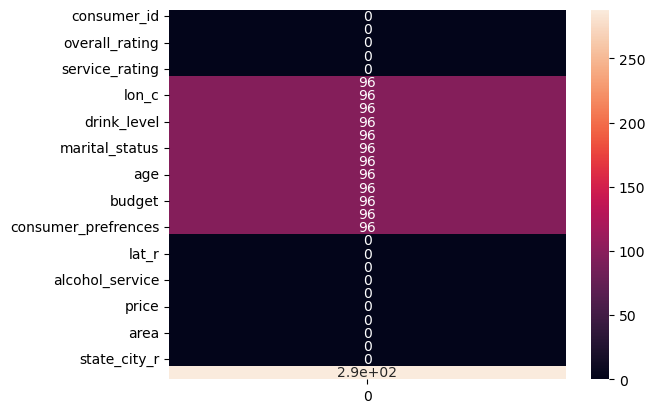

In [36]:
sns.heatmap(pd.DataFrame(df.isna().sum()), annot=True)

There are 96 consumers on the survey that their data is missing.

In [37]:
#calculating the distance between consumers and restaurants
distances = pd.DataFrame(df.dropna(subset=['lat_c']).apply(lambda x: geopy.distance.geodesic(tuple([x['lat_c'], x['lon_c']]), tuple([x['lat_r'], x['lon_r']])),axis=1))
distances = df[['consumer_id', 'restaurant_id', 'lat_c']].dropna(subset=['lat_c']).join(distances).rename(columns = {0:'distance'}).drop('lat_c', axis=1)
distances['tuple'] = distances.apply(lambda x: tuple([x['consumer_id'], x['restaurant_id']]),axis=1)
df['tuple'] = df.apply(lambda x: tuple([x['consumer_id'], x['restaurant_id']]),axis=1)

df = df.merge(distances.drop(columns=['consumer_id', 'restaurant_id']), on='tuple', how='left').drop(['tuple', 'lat_c', 'lon_c', 'lat_r', 'lon_r'], axis=1)
df['distance'] = df['distance'].apply(lambda x: round(float(str(x).split(' ')[0]), 3))

In [38]:
px.scatter(df, x='distance', y='overall_rating',height=350, width=700, title='Distance Vs Rating')

It is also a good idea to limit distance to 20KM maximum to remove outliers.

In [39]:
px.density_contour(df, x='distance', y='overall_rating',height=350, width=700, title='Distance Vs Rating by Transportation Method', color='transportation_method')

Most consumers submitted ratings for closer restaurants.

In [40]:
#cuisin prefrence compliency analysis
df['cuisine'] = df['cuisine'].replace(np.nan, None)
df['consumer_prefrences'] = df['consumer_prefrences'].replace(np.nan, None)

df['intersection'] = df.apply(lambda x: list(set(x['cuisine']).intersection(set(x['consumer_prefrences']))) if (x['cuisine'] != None and x['consumer_prefrences'] != None) else None ,axis=1)
df['intersection_len'] = df['intersection'].apply(lambda x: len(x) if x != None else None)
df['intersection'].value_counts()

[]                           597
[Mexican]                    159
[Fast Food]                    5
[Pizzeria]                     4
[Bar]                          4
[Cafeteria]                    3
[Contemporary, Cafeteria]      3
[Japanese]                     3
[Italian]                      3
[American]                     2
[Bar, Cafeteria]               2
[Seafood]                      2
[Contemporary]                 1
[Bakery]                       1
[Family]                       1
[Burgers, Fast Food]           1
[Brewery, Bar]                 1
[Chinese]                      1
[Breakfast]                    1
[Pizzeria, Cafeteria]          1
Name: intersection, dtype: int64

In [41]:
px.density_heatmap(df,x = 'intersection_len', y='food_rating',height=350, width=700, title='food rating Vs intersectin of preferred cuisine')

In [42]:
px.density_heatmap(df.sort_values('distance'), x='price', y='overall_rating',height=350, width=700, title='price Vs rating')

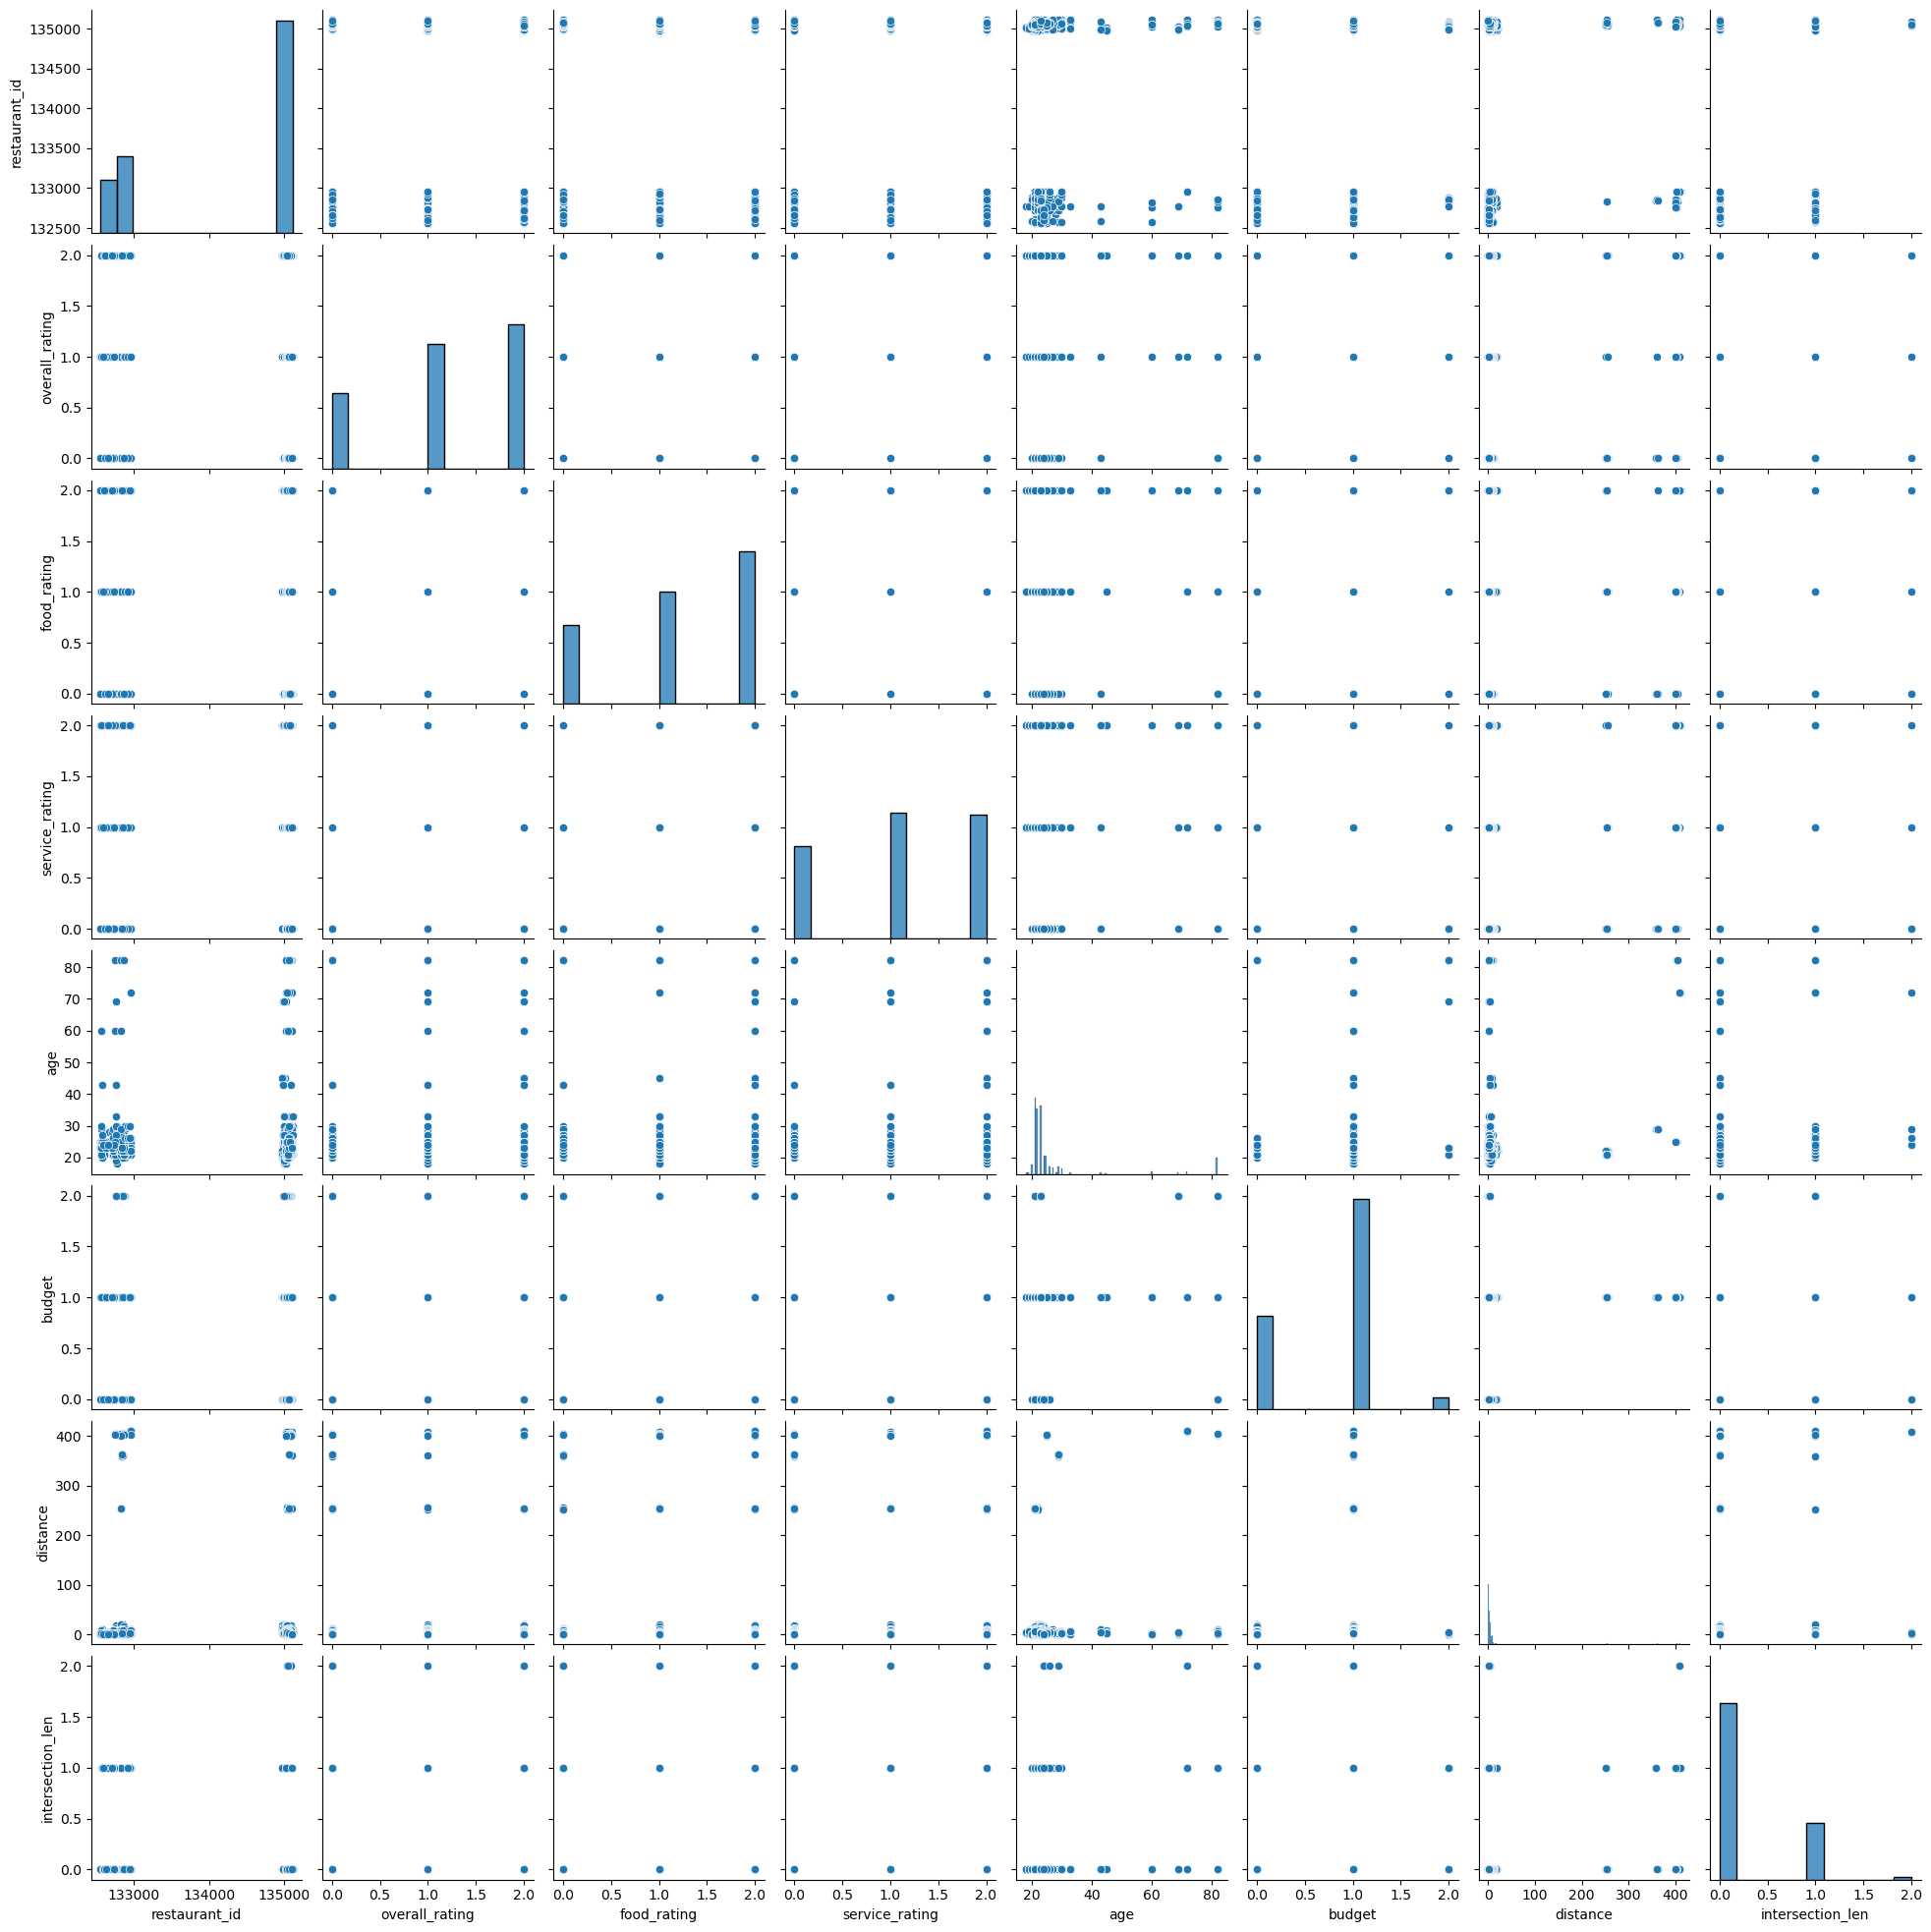

In [46]:
sns.pairplot(df)

In [44]:
# bad habits compliency analysis
def smoking (smoking_status):
  if smoking_status == 'Yes':
    return 1
  elif smoking_status == 'Smoking Section' or smoking_status == 'Bar Only': 
    return 0.5
  else:
    return 0

def drinker(drink_level):
  if drink_level == 'Casual Drinker':
    return 1
  elif drink_level == 'Social Drinker': 
    return 0.5
  else:
    return 0

def drinking(alcohol_service):
  if alcohol_service == 'Full Bar':
    return 1
  elif alcohol_service == 'Wine & Beer': 
    return 0.5
  else:
    return 0

bad_habits = df[['smoker', 'drink_level', 'smoking_allowed', 'alcohol_service', 'overall_rating', 'food_rating', 'service_rating']].dropna()

bad_habits['smoker'] = bad_habits['smoker'].apply(lambda x: 1 if x=='Yes' else 0)
bad_habits['smoking_allowed'] = bad_habits['smoking_allowed'].apply(lambda x: smoking(x))
bad_habits['drink_level'] = bad_habits['drink_level'].apply(lambda x: drinker(x))
bad_habits['alcohol_service'] = bad_habits['alcohol_service'].apply(lambda x: drinking(x))

bad_habits['drinking_compliency'] = bad_habits['drink_level'] * bad_habits['alcohol_service'] 
bad_habits['smoking_compliency'] = bad_habits['smoker'] * bad_habits['smoking_allowed'] 
bad_habits['total_compliency'] = bad_habits['smoking_compliency'] +  bad_habits['drinking_compliency']

bad_habits_result = pd.DataFrame(bad_habits[['total_compliency', 'service_rating']].groupby('total_compliency', as_index=False).apply(lambda x: x.value_counts())).reset_index()
bad_habits_result = bad_habits_result.merge(bad_habits_result.groupby('total_compliency', as_index=False).sum()[['total_compliency', 0]], on='total_compliency', how='left').rename(columns = {'0_x':'n', '0_y':'total'})
bad_habits_result['percentage'] = bad_habits_result['n'] / bad_habits_result['total']
bad_habits_result = pd.DataFrame(bad_habits_result.groupby(['total_compliency', 'service_rating']).apply(lambda x: x['percentage']))
bad_habits_result

percentage
total_compliency service_rating               
0.00             0              2     0.269377
                 1              0     0.387548
                 2              1     0.343075
0.25             0              5     0.142857
                 1              4     0.324675
                 2              3     0.532468
0.50             0              7     0.333333
                 1              8     0.296296
                 2              6     0.370370
0.75             0              11    0.090909
                 1              9     0.454545
                 2              10    0.454545
1.00             0              14    0.276596
                 1              12    0.404255
                 2              13    0.319149
1.50             0              17    0.142857
                 1              16    0.285714
                 2              15    0.571429
2.00             1              18    1.000000

In [45]:
px.histogram(data_frame=df, x='state_city_c', color='state_city_r',height=500, width=900, title='How many times did survey takers visit other cities?')

It is possible to continue this analysis furthermore but since we didn't specify any main questions, hypotheses or decision making process about the data, I tried to do more analysis about more interesting subjects though it is undeniable that there is no limit to put more time and effort on alaysing this data.
Best regards and thank you for your time. 